#Simple Autoencoder

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [2]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

#Torch
import torch
from torch import nn, optim
import torch.nn.functional as F

#Torch wrapper
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LRScheduler

#Utilities
import os
import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Download and Parase Data

In [0]:
%%capture
#Get data, small file so no if
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('no_rfe_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-6Z60VHL0gk3pd8hKF7-btW_cM_DWTB6' -O no_rfe_scaled0_1.csv
if not os.path.isfile('models.7z'): 
    !wget 'https://drive.google.com/uc?export=download&id=1RPhLO70ip98tvbb4YImXPtEn1Sgz9svy' -O models.7z
    !7z x models.7z

In [0]:
# data_file = 'all_scaled0_1.csv'
# folder = 'models/all/'
data_file = 'no_rfe_scaled0_1.csv'
folder = 'models/no_rfe/'

In [5]:
data = pd.read_csv(data_file,index_col=0)
labels = data['label']
run = data['run']
chunkID = data['chunkID']
period = data['period']
data = data.drop(['label','chunkID','run','period'], axis = 1)

no_samples, no_features = data.shape

print(no_samples, no_features)
print(labels.value_counts())

data.head()

3429 133
0.0    3262
1.0     167
Name: label, dtype: int64


,bz,meanTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeCTPCncl,slopeCTPCnclErr,hasRawQA,rawSignalCounter,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZAchi2,slopedZAchi2,offsetdZCPos,offsetdZAchi2Pos,slopedZAchi2Pos,offsetdZCchi2Pos,slopedZCchi2Pos,slopedZANeg,offsetdZCNeg,slopedZCNeg,offsetdZAchi2Neg,slopedZAchi2Neg,offsetdZCchi2Neg,slopedZCchi2Neg,offsetdRC,offsetdRAchi2,slopedRAchi2,offsetdRCchi2,slopedRCchi2,dcarAP0,dcarCP0,...,dcar_negA_chi2,dcar_negA_0_Err,dcar_negA_1_Err,dcar_negA_2_Err,dcaz_negA_0,dcaz_negA_1,dcaz_negA_0_Err,dcaz_negA_1_Err,dcaz_negA_2_Err,dcaz_negC_chi2,dcaz_negC_0_Err,dcaz_negC_1_Err,dcaz_negC_2_Err,dcar_negC_chi2,dcar_negC_0_Err,dcar_negC_1_Err,dcar_negC_2_Err,iroc_A_side,oroc_A_side,iroc_C_side,oroc_C_side,tpcItsMatchA,tpcItsMatchC,phiPullHighPt,ptPull,ptPullHighPt,yPullHighPt,zPull,zPullHighPt,lambdaPull,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,medianPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,meanVDriftCorr,rmsVDriftCorr
0,0.0,0.650378,0.586648,0.299807,0.567304,0.506033,0.029799,0.506033,0.661859,0.130696,0.432987,0.432987,1.0,0.630747,0.505639,0.456515,0.479150,0.029047,0.025431,0.066360,0.066360,0.422997,0.018955,0.018955,0.103951,0.103951,0.347511,0.486962,0.366647,0.135214,0.135214,0.154272,0.154272,0.104897,0.041065,0.041065,0.165264,0.165264,0.023750,0.012700,...,0.040081,0.089056,0.082068,0.091172,0.387952,0.529658,0.075152,0.073086,0.076870,0.049049,0.064750,0.062988,0.066403,0.096599,0.092639,0.089595,0.096029,1.0,1.0,1.0,1.0,0.532074,0.586826,0.558088,0.489128,0.478282,0.397318,0.303648,0.494765,0.564013,0.644374,0.643025,0.030060,0.644593,0.644385,0.643058,0.731516,0.730402,0.062052,0.033067
1,0.0,0.652363,0.579001,0.299619,0.553643,0.490807,0.028887,0.490807,0.662852,0.129801,0.431335,0.431335,1.0,0.630747,0.471739,0.656468,0.622429,0.028192,0.024807,0.098105,0.098105,0.626295,0.078152,0.078152,0.195836,0.195836,0.318030,0.662324,0.531044,0.126243,0.126243,0.205944,0.205944,0.184002,0.120756,0.120756,0.277622,0.277622,0.023131,0.013681,...,0.029575,0.088029,0.080961,0.090309,0.368447,0.537606,0.074312,0.072295,0.075983,0.053690,0.062965,0.061329,0.064488,0.080482,0.090666,0.087815,0.093847,1.0,1.0,1.0,1.0,0.529813,0.583827,0.618659,0.506106,0.508984,0.428699,0.344592,0.458420,0.559882,0.645829,0.644559,0.044541,0.646086,0.645843,0.644604,0.732617,0.731569,0.061865,0.008953
2,0.0,0.656779,0.582115,0.302841,0.576802,0.486826,0.028507,0.486826,0.664891,0.128520,0.414198,0.414198,1.0,0.630747,0.424595,0.774050,0.716557,0.027634,0.024176,0.102944,0.102944,0.748653,0.144460,0.144460,0.224404,0.224404,0.301996,0.760046,0.627993,0.067836,0.067836,0.248870,0.248870,0.229955,0.088526,0.088526,0.349164,0.349164,0.022454,0.013235,...,0.040652,0.088169,0.080976,0.090568,0.377793,0.560263,0.073681,0.071540,0.075483,0.070414,0.062983,0.061441,0.064412,0.067023,0.090231,0.087507,0.093285,1.0,1.0,1.0,1.0,0.534614,0.584458,0.572836,0.508496,0.493338,0.420849,0.341413,0.461882,0.561373,0.645117,0.644090,0.046651,0.645604,0.645142,0.644119,0.732088,0.731203,0.061668,0.027615
3,0.0,0.650338,0.590880,0.307098,0.573718,0.465535,0.029239,0.465535,0.657125,0.127972,0.413237,0.413237,1.0,0.630747,0.453121,0.865839,0.786867,0.029305,0.025690,0.074307,0.074307,0.849890,0.084640,0.084640,0.224069,0.224069,0.307199,0.833085,0.699755,0.059567,0.059567,0.296804,0.296804,0.268384,0.103972,0.103972,0.427887,0.427887,0.023129,0.016565,...,0.024053,0.088482,0.081358,0.090786,0.376294,0.584689,0.074933,0.072717,0.076810,0.095369,0.064623,0.062784,0.066359,0.065335,0.091349,0.088426,0.094600,1.0,1.0,1.0,1.0,0.520301,0.572863,0.602295,0.511802,0.537189,0.439337,0.365844,0.496001,0.529956,0.639891,0.637870,0.174869,0.639382,0.639929,0.637938,0.728152,0.726535,0.061461,0.007084
4,0.0,0.654262,0.591539,0.319091,0.584242,0.494138,0.028849,0.494138,0.663947,0.132655,

## Define The Model

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x)) #Only droput on last layer no ReLu
        return x

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

## Create Model Wrapper

In [8]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
#Parameters setting
max_epochs = 50
dropout = 0.3
batch_size = 128
start_lr = 0.00007 #Starting learning rate 

#Learning Rate scheduler
patience = 4 #After how many epochs with no improvemnt change LR
factor = 0.7 #Scale factor of LR 

#Encoding
latent_ratio = [0.5, 0.3, 0.1] #Must be 3 elements

In [10]:
#Create callbacks
model_path = 'simple_ae.pt'
checkpoint = Checkpoint(f_params=model_path, monitor='valid_loss_best')
scheduler = LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor = factor, patience = patience, threshold=1e-3) 

net = NeuralNetRegressor(
    SimpleAutoEncoder,
    module__no_features = no_features,
    module__lat_r = latent_ratio,
    module__dropout = dropout,
    batch_size = batch_size,
    lr=start_lr,
    optimizer = optim.Adam,
    max_epochs=max_epochs,
    train_split=skorch.dataset.CVSplit(3),
    device='cuda' if gpu else 'cpu',
    callbacks=[checkpoint, scheduler],
    verbose = 1
)
#Default criterion is <class 'torch.nn.modules.loss.MSELoss'>
print(net)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.SimpleAutoEncoder'>,
  module__dropout=0.3,
  module__lat_r=[0.5, 0.3, 0.1],
  module__no_features=133,
)


## Train Autoencoder

In [11]:
#Load model with lowest validation accuracy
net.initialize()  # This is important!

#Change training set to tensor and train network
X = torch.FloatTensor(data.to_numpy())
_ = net.fit(X,X) #output compared with imput, hide output

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.1225        0.1234     +  0.3513
      2        0.1213        0.1225     +  0.1314
      3        0.1202        0.1214     +  0.1407
      4        0.1188        0.1202     +  0.1273
      5        0.1173        0.1187     +  0.1269
      6        0.1151        0.1166     +  0.1350
      7        0.1120        0.1134     +  0.1377
      8        0.1074        0.1087     +  0.1302
      9        0.1002        0.1014     +  0.1312
     10        0.0899        0.0912     +  0.1587
     11        0.0770        0.0786     +  0.1268
     12        0.0625        0.0655     +  0.1280
     13        0.0485        0.0545     +  0.1356
     14        0.0388        0.0470     +  0.1422
     15        0.0319        0.0428     +  0.1278
     16        0.0274    

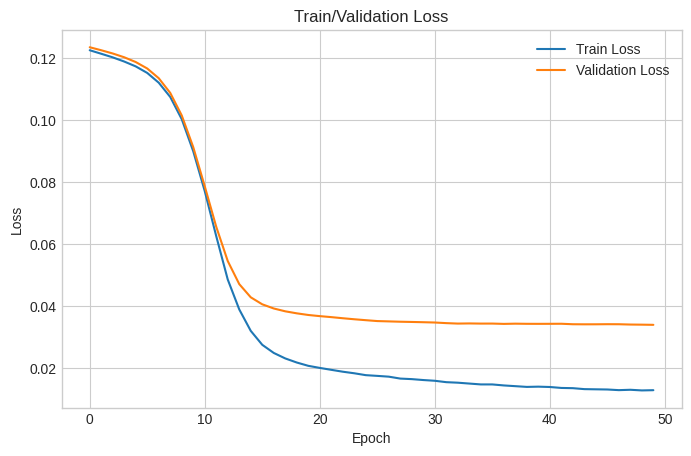

In [12]:
# Visualize training 

train_loss = [el['train_loss'] for el in net.history]
valid_loss = [el['valid_loss'] for el in net.history]

fig = plt.figure(figsize = (8,5), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss)
ax.plot(valid_loss)

ax.legend(['Train Loss', 'Validation Loss'])

ax.set_title('Train/Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss');